#### Pre-Processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
btc_df = pd.read_csv("C:/Users/USER/Documents/ITERA/Semester 7/SKRIPSI/A TERBARU/Code dan Data/bitcoin_data_2018_2025.csv")
btc_df['Date'] = pd.to_datetime(btc_df['Date'])
btc_df = btc_df.set_index('Date')
btc_df = btc_df.sort_index()

In [3]:
feature_cols = ['Close', 'High', 'Low', 'Open', 'Volume']
data_to_process = btc_df[feature_cols]

#### Split & Normalisasi

In [4]:
n = len(data_to_process)
train_size = int(n * 0.70)
val_size = int(n * 0.10)

train_data = data_to_process.iloc[:train_size]
val_data = data_to_process.iloc[train_size:train_size + val_size]
test_data = data_to_process.iloc[train_size + val_size:] # <-- test_data kini punya indeks tanggal

print(f"\n--- PEMBAGIAN DATA ---")
print(f"Total Data: {n}")
print(f"Data Latih (70%): {len(train_data)}")
print(f"Data Validasi (10%): {len(val_data)}")
print(f"Data Uji (20%): {len(test_data)}")


--- PEMBAGIAN DATA ---
Total Data: 2675
Data Latih (70%): 1872
Data Validasi (10%): 267
Data Uji (20%): 536


In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_data)
train_scaled = scaler.transform(train_data)
val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

In [6]:
print("\n--- DATA LATIH (NORMALISASI) ---")
print(train_scaled[:5])

print("\n--- DATA VALIDASI (NORMALISASI) ---")
print(val_scaled[:5])

print("\n--- DATA UJI (NORMALISASI) ---")
print(test_scaled[:5])



--- DATA LATIH (NORMALISASI) ---
[[0.0869576  0.08955155 0.07287754 0.09183156 0.02816661]
 [0.09230751 0.09395471 0.08008017 0.08731991 0.01247002]
 [0.0783498  0.09249121 0.07659216 0.09235121 0.01192342]
 [0.05780358 0.07768481 0.05642244 0.07827701 0.01827819]
 [0.0702197  0.06983706 0.04521162 0.05932623 0.03182391]]

--- DATA VALIDASI (NORMALISASI) ---
[[0.38132208 0.38544817 0.38061859 0.38569418 0.12024433]
 [0.38767339 0.38410248 0.38373242 0.38144609 0.09532844]
 [0.37417458 0.38965506 0.37297689 0.38751524 0.08751285]
 [0.3901319  0.38853329 0.37967672 0.37419356 0.0611898 ]
 [0.37706355 0.38332211 0.37739636 0.39008688 0.06624628]]

--- DATA UJI (NORMALISASI) ---
[[0.59402179 0.59182435 0.5930655  0.59089435 0.06279617]
 [0.61641442 0.61291101 0.59321275 0.59446639 0.06859533]
 [0.61848546 0.61231691 0.61046563 0.6164804  0.06509188]
 [0.60147608 0.60769143 0.60929265 0.61871925 0.04802771]
 [0.60630056 0.60123666 0.60976969 0.60176311 0.03293563]]


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Ambil hanya kolom Close dari data yang sudah dinormalisasi
close_all = scaler.transform(data_to_process)[:, 0]  # Kolom ke-0 = Close
dates_all = btc_df['Date'].values  # Array tanggal

# Hitung indeks pembagi
n = len(close_all)
train_end = int(n * 0.7)
val_end = train_end + int(n * 0.1)

# --- Plot ---
plt.figure(figsize=(14, 6))
plt.plot(dates_all, close_all, color='black', linewidth=1.5, label='Data Asli (Scaled)')

# Highlight Area
plt.axvspan(dates_all[0], dates_all[train_end], facecolor='royalblue', alpha=0.2, label='Training Data (70%)')
plt.axvspan(dates_all[train_end], dates_all[val_end], facecolor='gold', alpha=0.3, label='Validation Data (10%)')
plt.axvspan(dates_all[val_end], dates_all[-1], facecolor='lightcoral', alpha=0.3, label='Testing Data (20%)')

# Garis Pembatas
plt.axvline(dates_all[train_end], color='blue', linestyle='--', linewidth=2, label='Batas Training/Validation')
plt.axvline(dates_all[val_end], color='red', linestyle='--', linewidth=2, label='Batas Validation/Test')

# Judul dan Axis
plt.title("Hasil Pembagian Data Close Setelah Normalisasi")
plt.xlabel("Tanggal")
plt.ylabel("Scaled Value")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

KeyError: 'Date'

#### Windowing, Model Building dan Tuning Parameter.

In [10]:
# Fungsi Sliding Window
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length][0])
    return np.array(X), np.array(y)

# HyperModel sesuai proposal
class LSTMHyperModel(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()

        # Jumlah lapisan LSTM (1-3)
        num_layers = hp.Int("num_lstm_layers", 1, 3)

        for i in range(num_layers):
            return_sequences = i < num_layers - 1
            model.add(LSTM(
                units=hp.Choice(f"units_{i}", [64, 96, 128]),
                return_sequences=return_sequences,
                kernel_regularizer=regularizers.l2(hp.Choice("kernel_reg", [0.0001, 0.001, 0.01])),
                input_shape=self.input_shape if i == 0 else None
            ))
            model.add(Dropout(hp.Choice(f"dropout_{i}", [0.01, 0.1, 0.2])))

        model.add(Dense(1, activation='linear'))

        # Optimizer dan Learning Rate
        learning_rate = hp.Choice("learning_rate", [0.001, 0.01, 0.1])
        optimizer_name = hp.Choice("optimizer", ["adam", "rmsprop"])
        optimizer = Adam(learning_rate) if optimizer_name == "adam" else RMSprop(learning_rate)

        model.compile(
            optimizer=optimizer,
            loss="mean_squared_error",
            metrics=["mean_squared_error"]
        )
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [32, 64, 128]),
            **kwargs
        )

# --- Loop Tuning untuk Setiap Sequence Length ---
sequence_lengths = [7, 14, 21]
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

for seq_len in sequence_lengths:
    X_train, y_train = create_sequences(train_scaled, seq_len)
    X_val, y_val = create_sequences(val_scaled, seq_len)

    input_shape = (X_train.shape[1], X_train.shape[2])
    hypermodel = LSTMHyperModel(input_shape)

    tuner = kt.Hyperband(
        hypermodel,
        objective='val_mean_squared_error',
        max_epochs=150,
        factor=3,
        directory='NO_FNG',
        project_name=f'seq_len_{seq_len}',
        overwrite=False
    )

    tuner.search(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=150,
        callbacks=[early_stop],
        verbose=2
    )

Reloading Tuner from NO_FNG\seq_len_7\tuner0.json
Reloading Tuner from NO_FNG\seq_len_14\tuner0.json
Reloading Tuner from NO_FNG\seq_len_21\tuner0.json


In [11]:
from keras_tuner import Hyperband

sequence_lengths = [7, 14, 21]
best_overall_trial = None
best_score = float('inf')
best_seq_len = None

for seq_len in sequence_lengths:
    tuner = Hyperband(
        hypermodel=LSTMHyperModel(input_shape),  # Masukkan kembali hypermodel
        objective='val_mean_squared_error',
        max_epochs=150,
        factor=3,
        directory='NO_FNG',
        project_name=f'seq_len_{seq_len}'
    )

    # Cek apakah ada trial yang tersedia
    best_trials = tuner.oracle.get_best_trials(num_trials=1)
    if not best_trials:
        print(f"⚠️  Tidak ada trial yang ditemukan untuk seq_len={seq_len}. Lewati.")
        continue

    best_trial = best_trials[0]
    
    if best_trial.score < best_score:
        best_score = best_trial.score
        best_overall_trial = best_trial
        best_seq_len = seq_len

# Tampilkan hasil terbaik jika ada
if best_overall_trial:
    print("🏆 MODEL TERBAIK DARI SELURUH TUNING:")
    print(f"Sequence Length Terbaik: {best_seq_len}")
    print(f"Best Validation MSE: {best_score:.6f}")
    print("Hyperparameters:")
    for hp_name, hp_value in best_overall_trial.hyperparameters.values.items():
        print(f"  {hp_name}: {hp_value}")
else:
    print("❌ Tidak ada trial terbaik yang bisa ditampilkan.")


Reloading Tuner from NO_FNG\seq_len_7\tuner0.json
Reloading Tuner from NO_FNG\seq_len_14\tuner0.json
Reloading Tuner from NO_FNG\seq_len_21\tuner0.json
🏆 MODEL TERBAIK DARI SELURUH TUNING:
Sequence Length Terbaik: 14
Best Validation MSE: 0.000101
Hyperparameters:
  num_lstm_layers: 1
  units_0: 128
  kernel_reg: 0.0001
  dropout_0: 0.1
  learning_rate: 0.01
  optimizer: adam
  units_1: 96
  dropout_1: 0.1
  units_2: 96
  dropout_2: 0.01
  batch_size: 32
  tuner/epochs: 150
  tuner/initial_epoch: 50
  tuner/bracket: 3
  tuner/round: 3
  tuner/trial_id: 0203


In [13]:
import pandas as pd
from keras_tuner import Hyperband

sequence_lengths = [7, 14, 21]
all_trials = []

for seq_len in sequence_lengths:
    tuner = Hyperband(
        hypermodel=None,  # Tidak perlu digunakan saat hanya membaca ulang
        objective='val_mean_squared_error',
        max_epochs=150,
        factor=3,
        directory='NO_FNG',
        project_name=f'seq_len_{seq_len}'  # Ganti agar konsisten dgn tuning
    )

    for trial in tuner.oracle.trials.values():
        if trial.score is None:
            continue  # Lewati trial yang belum selesai atau gagal

        trial_data = trial.hyperparameters.values.copy()
        trial_data['val_mse'] = trial.score
        trial_data['sequence_length'] = seq_len
        trial_data['trial_id'] = trial.trial_id
        all_trials.append(trial_data)

# Buat DataFrame dari seluruh hasil trial
df_all_trials = pd.DataFrame(all_trials)

if not df_all_trials.empty:
    # Urutkan berdasarkan MSE terkecil
    df_all_trials = df_all_trials.sort_values(by='val_mse', ascending=True).reset_index(drop=True)

    # Simpan ke file CSV
    df_all_trials.to_csv("seluruh_hasil_tuning_lstm.csv", index=False)
    print("✅ Seluruh hasil tuning berhasil disimpan ke 'tuning_no_fng.csv'")
else:
    print("⚠️ Tidak ada trial yang valid ditemukan untuk disimpan.")


Reloading Tuner from NO_FNG\seq_len_7\tuner0.json
Reloading Tuner from NO_FNG\seq_len_14\tuner0.json
Reloading Tuner from NO_FNG\seq_len_21\tuner0.json
✅ Seluruh hasil tuning berhasil disimpan ke 'tuning_no_fng.csv'


Epoch 1/150


C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 58ms/step - loss: 0.0392 - mean_squared_error: 0.0379 - val_loss: 0.0017 - val_mean_squared_error: 5.0626e-04
Epoch 2/150
59/59 - 1s - 14ms/step - loss: 0.0021 - mean_squared_error: 9.9730e-04 - val_loss: 0.0013 - val_mean_squared_error: 3.2864e-04
Epoch 3/150
59/59 - 1s - 12ms/step - loss: 0.0019 - mean_squared_error: 9.6476e-04 - val_loss: 0.0010 - val_mean_squared_error: 2.2201e-04
Epoch 4/150
59/59 - 1s - 12ms/step - loss: 0.0016 - mean_squared_error: 8.1045e-04 - val_loss: 9.2285e-04 - val_mean_squared_error: 2.2735e-04
Epoch 5/150
59/59 - 1s - 14ms/step - loss: 0.0014 - mean_squared_error: 7.4995e-04 - val_loss: 8.1818e-04 - val_mean_squared_error: 2.1568e-04
Epoch 6/150
59/59 - 1s - 13ms/step - loss: 0.0013 - mean_squared_error: 7.2321e-04 - val_loss: 7.0143e-04 - val_mean_squared_error: 1.6957e-04
Epoch 7/150
59/59 - 1s - 13ms/step - loss: 0.0012 - mean_squared_error: 7.2784e-04 - val_loss: 6.3770e-04 - val_mean_squared_error: 1.6355e-04
Epoch 8/150
59/59 - 1s - 12

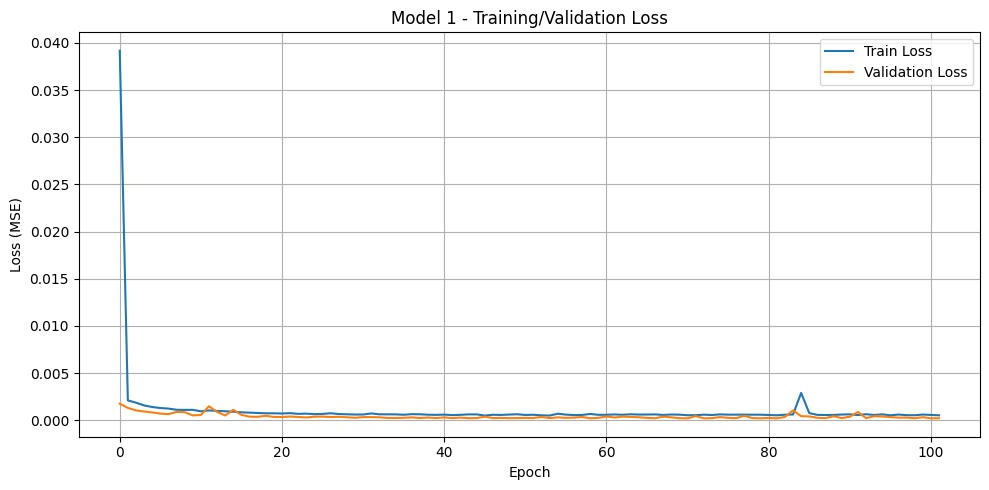

In [14]:
import os
import random

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Siapkan data
X_train, y_train = create_sequences(train_scaled, seq_length=best_seq_len)
X_val, y_val = create_sequences(val_scaled, seq_length=best_seq_len)

# Rekonstruksi HyperParameters
from keras_tuner.engine.hyperparameters import HyperParameters
hp = HyperParameters()
for name, value in best_overall_trial.hyperparameters.values.items():
    hp.values[name] = value

# Bangun model
input_shape = (X_train.shape[1], X_train.shape[2])
hypermodel = LSTMHyperModel(input_shape=input_shape)
final_model = hypermodel.build(hp)

# EarlyStopping seperti saat tuning
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Latih ulang model terbaik
history = final_model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=hp.get('batch_size'),
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=2
)

# --- Visualisasi Loss Training dan Validasi ---
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model 1 - Training/Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Prediksi

In [15]:
from tensorflow.keras.callbacks import Callback

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 12, 'figure.titlesize': 18, 'axes.titlesize': 14})

class WeightHistoryCallback(Callback):
    def __init__(self, layer_name):
        super().__init__()
        self.layer_name = layer_name
        self.weights_history = []
    def on_epoch_end(self, epoch, logs=None):
        for layer in self.model.layers:
            if self.layer_name in layer.name:
                self.weights_history.append(layer.get_weights()[0].copy())
                return

#Latih
trainval_scaled = np.concatenate([train_scaled, val_scaled], axis=0)
X_trainval, y_trainval = create_sequences(trainval_scaled, seq_length=best_seq_len)

hp = HyperParameters()
for name, value in best_overall_trial.hyperparameters.values.items():
    hp.values[name] = value

input_shape = (X_trainval.shape[1], X_trainval.shape[2])
hypermodel = LSTMHyperModel(input_shape=input_shape)
final_model = hypermodel.build(hp)

try:
    lstm_layer_name = [l.name for l in final_model.layers if 'lstm' in l.name.lower()][0]
    weight_callback = WeightHistoryCallback(layer_name=lstm_layer_name)
    callbacks_list = [weight_callback]
except IndexError:
    callbacks_list = []

history = final_model.fit(
    X_trainval, y_trainval,
    epochs=150,
    batch_size=hp.get('batch_size'),
    callbacks=callbacks_list,
    verbose=2
)

#Prediksi
X_test, y_test = create_sequences(test_scaled, seq_length=best_seq_len)
y_pred_scaled = final_model.predict(X_test)

# Fungsi untuk inverse transform hanya kolom Close (kolom ke-0)
def inverse_transform_close_only(y_scaled, scaler):
    dummy_full = np.zeros((len(y_scaled), len(feature_cols)))
    dummy_full[:, 0] = y_scaled.ravel()
    return scaler.inverse_transform(dummy_full)[:, 0]

y_test_actual = inverse_transform_close_only(y_test, scaler)
y_pred_actual = inverse_transform_close_only(y_pred_scaled, scaler)

test_mape = mean_absolute_percentage_error(y_test_actual, y_pred_actual) * 100
print(f"\nMAPE pada Data Uji: {test_mape:.2f}%\n")


Epoch 1/150


C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 - 2s - 36ms/step - loss: 0.0296 - mean_squared_error: 0.0284
Epoch 2/150
67/67 - 1s - 9ms/step - loss: 0.0020 - mean_squared_error: 0.0010
Epoch 3/150
67/67 - 1s - 10ms/step - loss: 0.0016 - mean_squared_error: 8.3786e-04
Epoch 4/150
67/67 - 1s - 10ms/step - loss: 0.0014 - mean_squared_error: 8.4737e-04
Epoch 5/150
67/67 - 1s - 11ms/step - loss: 0.0013 - mean_squared_error: 8.0637e-04
Epoch 6/150
67/67 - 1s - 11ms/step - loss: 0.0011 - mean_squared_error: 6.9776e-04
Epoch 7/150
67/67 - 1s - 11ms/step - loss: 0.0010 - mean_squared_error: 6.5823e-04
Epoch 8/150
67/67 - 1s - 10ms/step - loss: 9.9071e-04 - mean_squared_error: 6.5946e-04
Epoch 9/150
67/67 - 1s - 10ms/step - loss: 9.3504e-04 - mean_squared_error: 6.3912e-04
Epoch 10/150
67/67 - 1s - 11ms/step - loss: 9.8518e-04 - mean_squared_error: 7.1576e-04
Epoch 11/150
67/67 - 1s - 10ms/step - loss: 9.0838e-04 - mean_squared_error: 6.6069e-04
Epoch 12/150
67/67 - 1s - 11ms/step - loss: 8.5345e-04 - mean_squared_error: 6.2324e-04
Ep

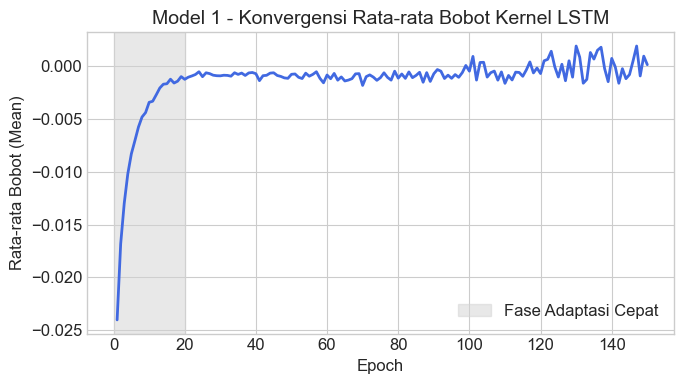

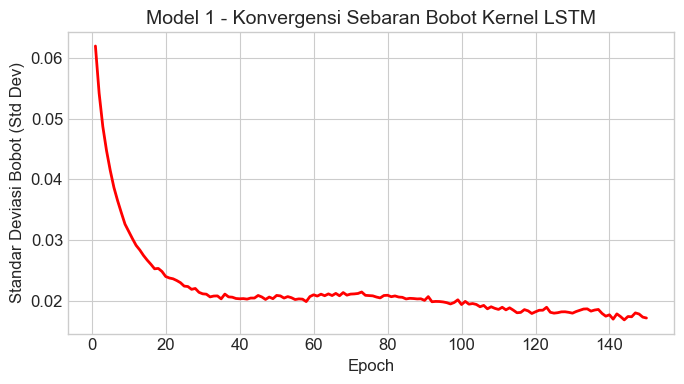

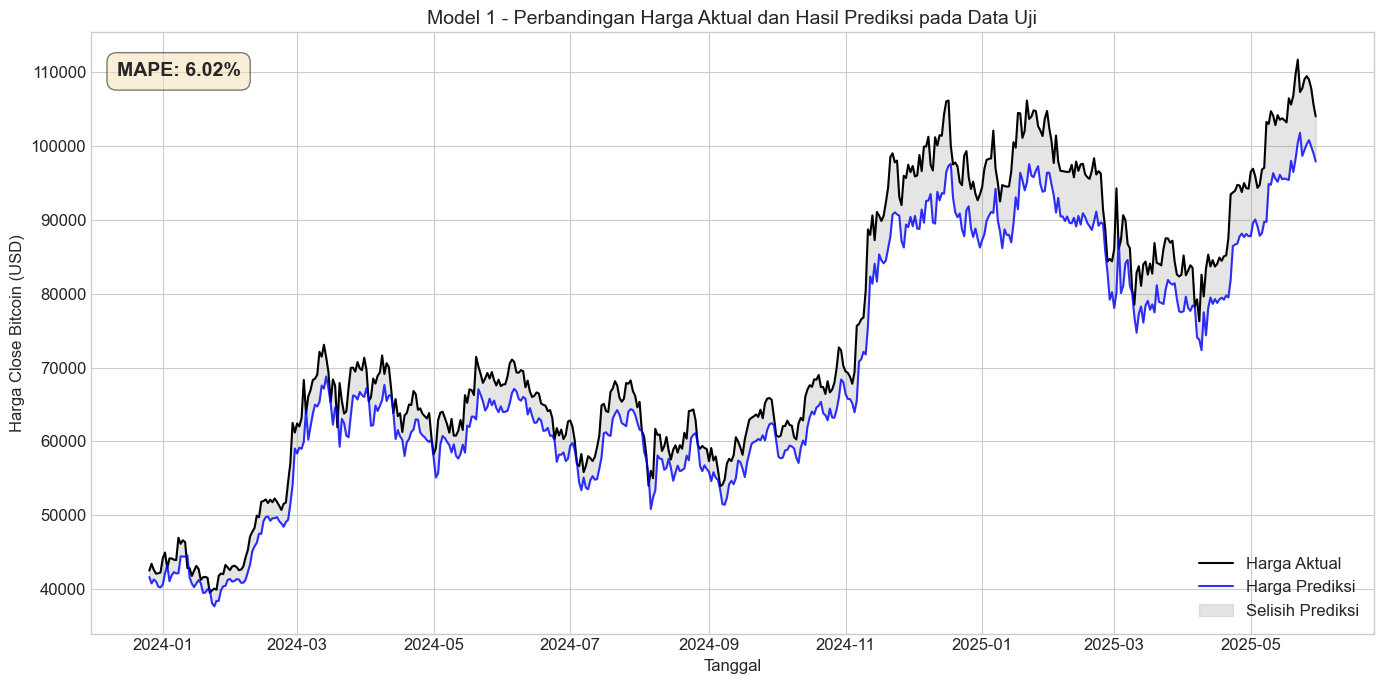

In [16]:
test_dates = test_data.index

if callbacks_list:
    weights_over_time = weight_callback.weights_history
    mean_weights = [np.mean(w) for w in weights_over_time]
    std_weights = [np.std(w) for w in weights_over_time]
    epochs_trained = range(1, len(mean_weights) + 1)
    
    plt.figure(figsize=(7, 4))
    plt.plot(epochs_trained, mean_weights, color='royalblue', linewidth=2)
    plt.axvspan(0, 20, color='lightgray', alpha=0.5, label='Fase Adaptasi Cepat')
    plt.title(f'Model 1 - Konvergensi Rata-rata Bobot Kernel LSTM')
    plt.xlabel('Epoch')
    plt.ylabel('Rata-rata Bobot (Mean)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.plot(epochs_trained, std_weights, color='red', linewidth=2)
    plt.title(f'Model 1 - Konvergensi Sebaran Bobot Kernel LSTM')
    plt.xlabel('Epoch')
    plt.ylabel('Standar Deviasi Bobot (Std Dev)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_dates = test_dates[best_seq_len:]
plt.figure(figsize=(14, 7))
plt.plot(plot_dates, y_test_actual, label='Harga Aktual', color='black', linewidth=1.5)
plt.plot(plot_dates, y_pred_actual, label='Harga Prediksi', color='blue', linewidth=1.5, alpha=0.8)
plt.fill_between(plot_dates, y_test_actual, y_pred_actual, color='gray', alpha=0.2, label='Selisih Prediksi')

plt.text(0.02, 0.95, f'MAPE: {test_mape:.2f}%', transform=plt.gca().transAxes,
         fontsize=14, fontweight='bold', verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

plt.title('Model 1 - Perbandingan Harga Aktual dan Hasil Prediksi pada Data Uji')
plt.xlabel('Tanggal')
plt.ylabel('Harga Close Bitcoin (USD)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
final_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 128)                 │          68,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 206,213 (805.52 KB)

 Trainable params: 68,737 (268.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 137,476 (537.02 KB)

In [18]:
import pandas as pd

# Pastikan bentuknya 1D
y_test_actual = y_test_actual.flatten()
y_pred_actual = y_pred_actual.flatten()

# Simpan ke CSV
df = pd.DataFrame({
    'y_true': y_test_actual,
    'y_pred': y_pred_actual
})

df.to_csv('hasil_prediksi_model_1.csv', index=False)
